In [1]:
from typing import Dict, List
import json
from collections import namedtuple
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

metric_names = [
    "Improvement::CII",
    "Improvement::LSR",
    "Improvement::FSIM",
    "Distortion::PSNR",
    "Distortion::SSIM",
    "Distortion::LPIPS",
    "Artifacts::RNS",
    "Artifacts::BRISQUE",
]


In [2]:
MetricResult = namedtuple("MetricResult", ("metric_name", "result"))


def deserialize_metrics(json_str: str) -> Dict[str, Dict[str, List[MetricResult]]]:
    data = json.loads(json_str)

    deserialized_data = {}

    for image_hash, experiments in data.items():
        deserialized_data[image_hash] = {}

        for exp_name, metrics_dict in experiments.items():
            # Convert dictionary back to list of MetricResult with Python floats
            metrics_list = [
                MetricResult(metric_name=metric_name, result=float(result))
                for metric_name, result in metrics_dict.items()
            ]

            deserialized_data[image_hash][exp_name] = metrics_list

    return deserialized_data


def build_experiment_dataframes(
    metrics_dict: Dict[str, Dict[str, List[MetricResult]]],
) -> Dict[str, pd.DataFrame]:
    """
    Para cada experimento, crea un DataFrame donde cada fila es una imagen
    y cada columna corresponde a una métrica con su resultado.
    Devuelve un diccionario experimento -> DataFrame.
    """
    # Identificar todos los experimentos únicos
    experiments = set()
    for img_exps in metrics_dict.values():
        experiments.update(img_exps.keys())

    # Inicializar dict de DataFrames
    dfs: Dict[str, pd.DataFrame] = {}
    for exp in experiments:
        rows = []
        for image_id, img_exps in metrics_dict.items():
            if exp in img_exps:
                row = {"image_id": image_id}
                for metric in img_exps[exp]:
                    row[metric.metric_name] = metric.result
                rows.append(row)
        dfs[exp] = pd.DataFrame(rows).set_index("image_id")
    return dfs

In [3]:
with open("exp_out/out.json", "r") as f:
    sample_json = f.read()

metrics = deserialize_metrics(sample_json)
dfs = build_experiment_dataframes(metrics)
# %%
for name, df in dfs.items():
    df["Experiment"] = name


combined_df = pd.concat(dfs.values(), ignore_index=True)

In [4]:
combined_df

,Improvement::CII,Improvement::LSR,Improvement::FSIM,Distortion::PSNR,Distortion::SSIM,Distortion::LPIPS,Artifacts::RNS,Artifacts::BRISQUE,Experiment
0,0.910944,42.638138,0.874513,73.818122,0.999817,0.000039,0.049338,115.013855,Enhance Energy by 1.5
1,0.908425,42.259136,0.875223,73.791113,0.999816,0.000039,0.049635,115.034912,Enhance Energy by 1.5
2,0.901935,42.088810,0.876399,73.311596,0.999766,0.000040,0.051221,115.031494,Enhance Energy by 1.5
3,0.572901,42.899635,0.828319,64.984791,0.997170,0.000062,0.133558,115.041199,Enhance Energy by 1.5
4,0.518845,44.296131,0.768764,61.547475,0.993628,0.000098,0.191937,114.846588,Enhance Energy by 1.5
...,...,...,...,...,...,...,...,...,...
580,1.498787,11.017125,0.567448,63.091951,0.996024,0.000346,0.136802,111.619537,"Gaussian Scale Mask with center_scale=N/2, sig..."
581,1.725627,16.240250,0.589123,62.949163,0.995917,0.000358,0.144096,112.079437,"Gaussian Scale Mask with center_scale=N/2, sig..."
582,1.414317,10.826291,0.569971,63.849679,0.996693,0.000320,0.126955,112.397858,"Gaussian Scale Mask with center_scale=N/2, sig..."
583,1.729733,9.668676,0.602258,63.343758,0.996277,0.000264,0.138791,109.540009,"Gaussian Scale Mask with center_scale=N/2, sig..."


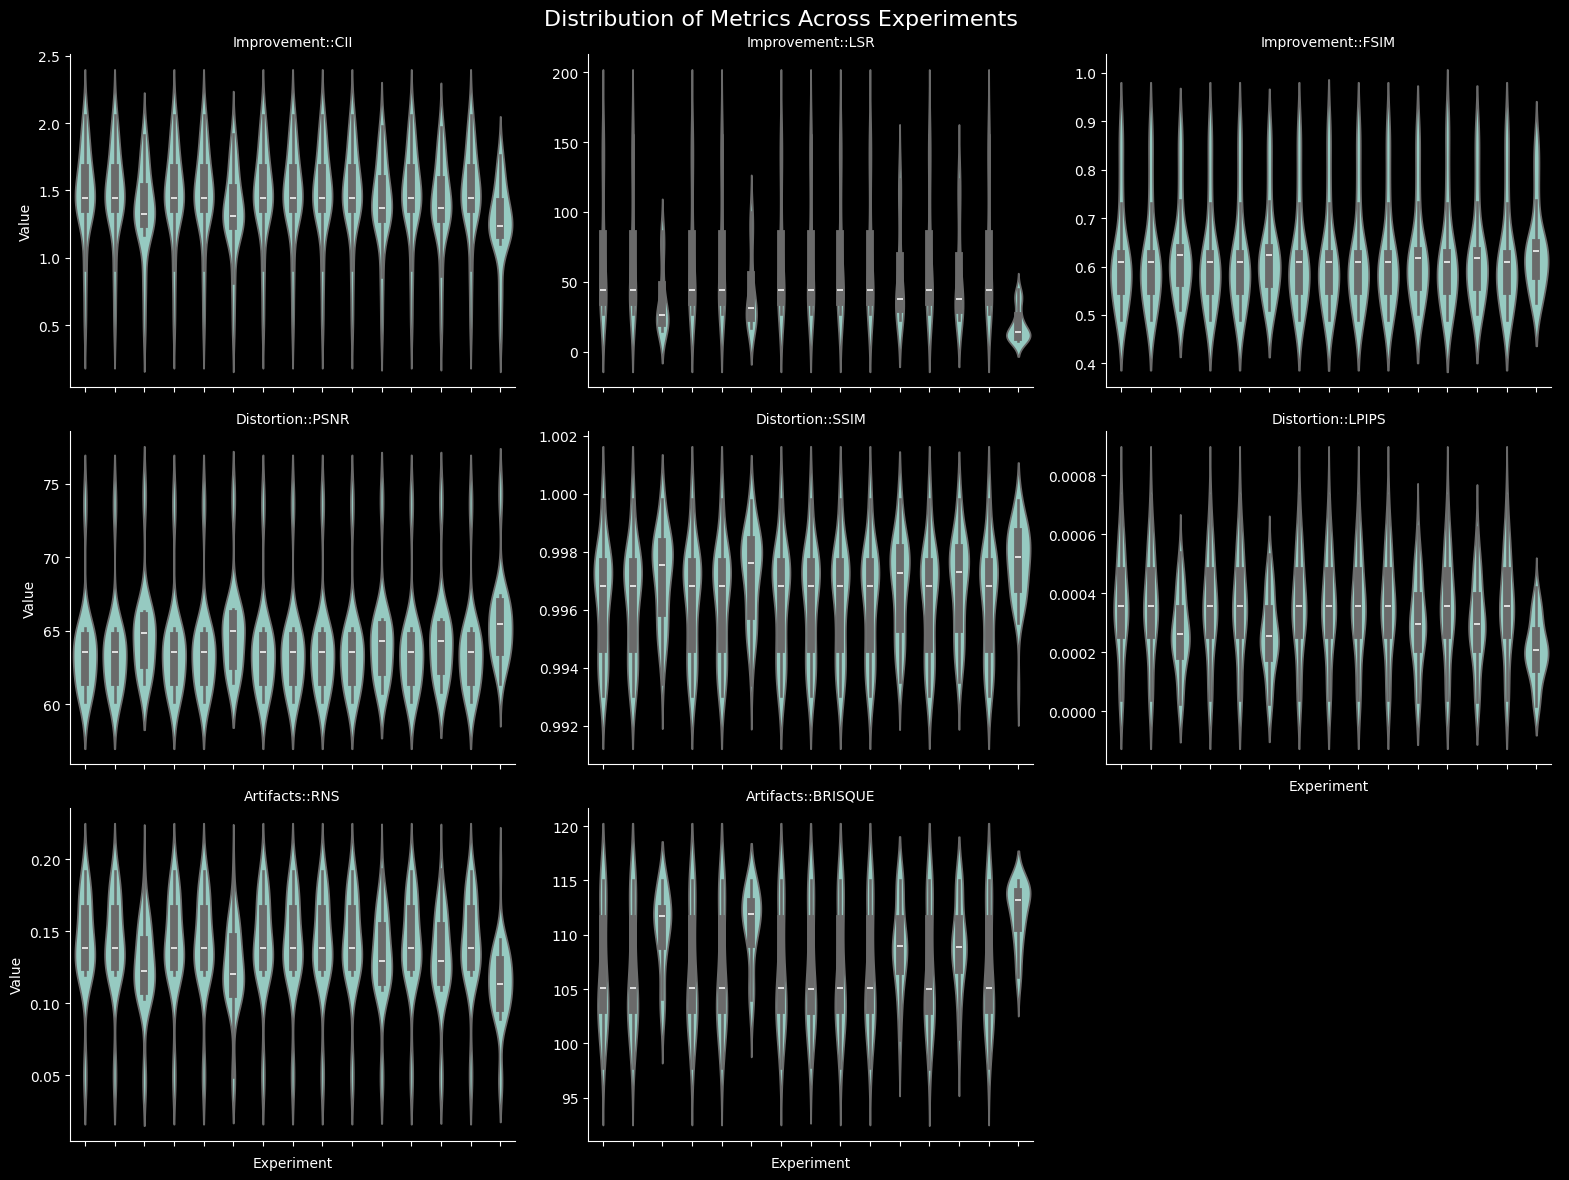

In [5]:
long_df = pd.melt(
    combined_df,
    id_vars="Experiment", # type: ignore
    value_vars=metric_names,
    var_name="Metric",
    value_name="Value",
)

g = sns.catplot(
    data=long_df,
    x="Experiment",
    y="Value",
    col="Metric",
    kind="violin",
    sharey=False,
    col_wrap=3,
    height=4,
    aspect=1.3,
)

g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.93)
g.fig.suptitle("Distribution of Metrics Across Experiments", fontsize=16)

plt.tight_layout()
plt.show()

In [6]:
normality_results = {}

for exp, df in dfs.items():
    normality_results[exp] = {}
    for metric in metric_names:
        values = df[metric].dropna()
        n = len(values)
        if n < 3:
            # Not enough data for normality test
            normality_results[exp][metric] = None
            continue
        if n <= 5000:
            stat, p = stats.shapiro(values)
        else:
            stat, p = stats.kstest(values, "norm", args=(values.mean(), values.std()))
        normality_results[exp][metric] = bool(p > 0.05)

normality_results

{'Enhance Energy by 1.5': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': False,
  'Distortion::LPIPS': True,
  'Artifacts::RNS': False,
  'Artifacts::BRISQUE': False},
 'Enhance Energy by 10': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': False,
  'Distortion::LPIPS': True,
  'Artifacts::RNS': False,
  'Artifacts::BRISQUE': False},
 'Bandpass Mask with low_scale=15, high_scale=20': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': True,
  'Distortion::LPIPS': True,
  'Artifacts::RNS': False,
  'Artifacts::BRISQUE': False},
 'Exponential Scale Mask with decay_rate=0.1': {'Improvement::CII': False,
  'Improvement::LSR': False,
  'Improvement::FSIM': False,
  'Distortion::PSNR': False,
  'Distortion::SSIM': False,
  'Disto

In [7]:
metric_normality = {}

for metric in metric_names:
    metric_values = combined_df[metric].dropna()
    n = len(metric_values)
    if n < 3:
        metric_normality[metric] = None
        continue
    if n <= 5000:
        stat, p = stats.shapiro(metric_values)
    else:
        stat, p = stats.kstest(
            metric_values, "norm", args=(metric_values.mean(), metric_values.std())
        )
    metric_normality[metric] = bool(p > 0.05)

metric_normality

{'Improvement::CII': False,
 'Improvement::LSR': False,
 'Improvement::FSIM': False,
 'Distortion::PSNR': False,
 'Distortion::SSIM': False,
 'Distortion::LPIPS': False,
 'Artifacts::RNS': False,
 'Artifacts::BRISQUE': False}

In [8]:
from scipy.stats import mannwhitneyu
from itertools import combinations

for metric in metric_names:
    print(f"Pairwise comparisons for {metric}:")
    exp_names = list(dfs.keys())
    for exp1, exp2 in combinations(exp_names, 2):
        values1 = dfs[exp1][metric].dropna()
        values2 = dfs[exp2][metric].dropna()
        if len(values1) < 2 or len(values2) < 2:
            print(f"  Not enough data for {exp1} vs {exp2}")
            continue
        stat, p = mannwhitneyu(values1, values2, alternative="two-sided")
        print(f"  {exp1} vs {exp2}: U={stat:.3f}, p={p:.4f}", end=" ")
        if p < 0.05:
            print("(significant)")
        else:
            print("(not significant)")
    print()

Pairwise comparisons for Improvement::CII:
  Enhance Energy by 1.5 vs Enhance Energy by 10: U=760.500, p=1.0000 (not significant)
  Enhance Energy by 1.5 vs Bandpass Mask with low_scale=15, high_scale=20: U=974.000, p=0.0333 (significant)
  Enhance Energy by 1.5 vs Exponential Scale Mask with decay_rate=0.1: U=760.500, p=1.0000 (not significant)
  Enhance Energy by 1.5 vs Threshold Coefficients at 0.001: U=760.500, p=1.0000 (not significant)
  Enhance Energy by 1.5 vs Highpass Mask with cutoff_scale=10: U=1003.000, p=0.0156 (significant)
  Enhance Energy by 1.5 vs Exponential Scale Mask with decay_rate=0.01: U=760.500, p=1.0000 (not significant)
  Enhance Energy by 1.5 vs Threshold Coefficients at 0.05: U=768.000, p=0.9442 (not significant)
  Enhance Energy by 1.5 vs Enhance Energy by 3.0: U=760.500, p=1.0000 (not significant)
  Enhance Energy by 1.5 vs Gaussian Scale Mask with center_scale=N/2, sigma=4.0: U=760.500, p=1.0000 (not significant)
  Enhance Energy by 1.5 vs Highpass Mask w

In [9]:
# Define metric directions: True if higher is better, False if lower is better
metric_directions = {
    "Improvement::CII": True,
    "Improvement::LSR": True,
    "Improvement::FSIM": True,
    "Distortion::PSNR": True,
    "Distortion::SSIM": True,
    "Distortion::LPIPS": False,
    "Artifacts::RNS": False,
    "Artifacts::BRISQUE": False,
}


def is_different(metric, exp1, exp2, dfs):
    values1 = dfs[exp1][metric].dropna()
    values2 = dfs[exp2][metric].dropna()
    if len(values1) < 2 or len(values2) < 2:
        print(f"  Not enough data for {exp1} vs {exp2}")
        return False
    _, p = mannwhitneyu(values1, values2, alternative="two-sided")
    return p < 0.05


def is_different_anova(metric, exp1, exp2, dfs):
    """
    Uses one-way ANOVA (scipy.stats.f_oneway) to test if the means of two samples are significantly different.
    Assumes normality and equal variances of the samples.
    Returns True if p < 0.05, otherwise False.
    """
    values1 = dfs[exp1][metric].dropna()
    values2 = dfs[exp2][metric].dropna()
    if len(values1) < 2 or len(values2) < 2:
        print(f"  Not enough data for {exp1} vs {exp2}")
        return False
    _, p = stats.f_oneway(values1, values2)
    return p < 0.05


# Define expected/ideal values for each metric
expected_values = {
    "Improvement::CII": 1.0,
    "Improvement::LSR": 1.0,
    "Improvement::FSIM": 1.0,
    "Distortion::PSNR": float("inf"),
    "Distortion::SSIM": 1.0,
    "Distortion::LPIPS": 0.0,
    "Artifacts::RNS": 0.0,
    "Artifacts::BRISQUE": 0.0,
}


def compare_experiments(
    exp1,
    exp2,
    dfs,
    metric_directions=metric_directions,
    expected_values=expected_values,
):
    """
    Compare two experiments across all metrics using expected values.
    Returns a dict: metric -> closer experiment (or 'tie')
    """
    results = {}
    df1 = dfs[exp1]
    df2 = dfs[exp2]
    common_images = df1.index.intersection(df2.index)
    for metric, higher_is_better in metric_directions.items():
        if metric not in df1.columns or metric not in df2.columns:
            results[metric] = "N/A"
            continue

        significant = is_different(metric, exp1, exp2, dfs)
        if not significant:
            results[metric] = "tie"
            continue

        vals1 = df1.loc[common_images, metric].dropna()
        vals2 = df2.loc[common_images, metric].dropna()
        valid_idx = vals1.index.intersection(vals2.index)
        if len(valid_idx) == 0:
            results[metric] = "N/A"
            continue
        mean1 = vals1.loc[valid_idx].mean()
        mean2 = vals2.loc[valid_idx].mean()
        ideal = expected_values.get(metric, None)
        if ideal is None:
            results[metric] = "N/A"
            continue
        # For infinite ideal (e.g., PSNR), use higher value as closer
        if ideal == float("inf"):
            if abs(mean1 - mean2) < 1e-6:
                results[metric] = "tie"
            elif mean1 > mean2:
                results[metric] = exp1
            else:
                results[metric] = exp2
        else:
            dist1 = abs(mean1 - ideal)
            dist2 = abs(mean2 - ideal)
            if abs(dist1 - dist2) < 1e-6:
                results[metric] = "tie"
            elif dist1 < dist2:
                results[metric] = exp1
            else:
                results[metric] = exp2
    return results


In [10]:
# Example usage:
exp_names = list(dfs.keys())
comparison_results = {}
for exp1, exp2 in combinations(exp_names, 2):
    comparison_results[(exp1, exp2)] = compare_experiments(exp1, exp2, dfs)

In [11]:
def get_best_experiment(comparison_results):
    """
    Given the pairwise comparison_results, count how many times each experiment
    is closer to the ideal value (i.e., 'wins' per metric across all pairs).
    Returns a sorted list of (experiment, win_count) tuples.
    """
    win_counts = {}
    for (exp1, exp2), metrics in comparison_results.items():
        for metric, winner in metrics.items():
            if winner in (exp1, exp2):
                win_counts[winner] = win_counts.get(winner, 0) + 1
    # Sort by win count descending
    return sorted(win_counts.items(), key=lambda x: x[1], reverse=True)


best_experiments = get_best_experiment(comparison_results)
print("Best experiments by win count:")

for rank, (exp, count) in enumerate(best_experiments, 1):
    print(f"{rank}. {exp}: {count} wins")

Best experiments by win count:
1. Gaussian Scale Mask with center_scale=N/2, sigma=1.0: 77 wins
2. Bandpass Mask with low_scale=15, high_scale=20: 62 wins
3. Highpass Mask with cutoff_scale=10: 62 wins
4. Highpass Mask with cutoff_scale=5: 12 wins
5. Bandpass Mask with low_scale=5, high_scale=10: 12 wins
6. Enhance Energy by 1.5: 5 wins
7. Enhance Energy by 10: 5 wins
8. Exponential Scale Mask with decay_rate=0.1: 5 wins
9. Threshold Coefficients at 0.001: 5 wins
10. Exponential Scale Mask with decay_rate=0.01: 5 wins
11. Threshold Coefficients at 0.05: 5 wins
12. Enhance Energy by 3.0: 5 wins
13. Gaussian Scale Mask with center_scale=N/2, sigma=4.0: 5 wins
14. Threshold Coefficients at 0.1: 5 wins
15. Gaussian Scale Mask with center_scale=N/2, sigma=6.0: 5 wins


In [12]:
def get_best_experiment_with_lsr_priority(comparison_results):
    """
    Like get_best_experiment, but LSR metric counts as 3 'wins' (most important).
    """
    win_counts = {}
    for (exp1, exp2), metrics in comparison_results.items():
        for metric, winner in metrics.items():
            if winner in (exp1, exp2):
                # Give LSR extra weight
                weight = 3 if metric == "Distortion::SSIM" else 1
                win_counts[winner] = win_counts.get(winner, 0) + weight
    return sorted(win_counts.items(), key=lambda x: x[1], reverse=True)


best_experiments_lsr = get_best_experiment_with_lsr_priority(comparison_results)
print("Best experiments by win count (LSR prioritized):")
for rank, (exp, count) in enumerate(best_experiments_lsr, 1):
    print(f"{rank}. {exp}: {count} weighted wins")

Best experiments by win count (LSR prioritized):
1. Gaussian Scale Mask with center_scale=N/2, sigma=1.0: 101 weighted wins
2. Bandpass Mask with low_scale=15, high_scale=20: 82 weighted wins
3. Highpass Mask with cutoff_scale=10: 82 weighted wins
4. Highpass Mask with cutoff_scale=5: 12 weighted wins
5. Bandpass Mask with low_scale=5, high_scale=10: 12 weighted wins
6. Enhance Energy by 1.5: 5 weighted wins
7. Enhance Energy by 10: 5 weighted wins
8. Exponential Scale Mask with decay_rate=0.1: 5 weighted wins
9. Threshold Coefficients at 0.001: 5 weighted wins
10. Exponential Scale Mask with decay_rate=0.01: 5 weighted wins
11. Threshold Coefficients at 0.05: 5 weighted wins
12. Enhance Energy by 3.0: 5 weighted wins
13. Gaussian Scale Mask with center_scale=N/2, sigma=4.0: 5 weighted wins
14. Threshold Coefficients at 0.1: 5 weighted wins
15. Gaussian Scale Mask with center_scale=N/2, sigma=6.0: 5 weighted wins


In [13]:
def compare_metrics(
    df_a: pd.DataFrame,
    df_b: pd.DataFrame,
    weights: Dict[str, float] = {},
    lower_is_better=['Distortion::LPIPS', 'Artifacts::RNS', 'Artifacts::BRISQUE'],
    ignore=["image_id", "Experiment"],
):
    df_a_filtered = df_a.drop(columns=[col for col in ignore if col in df_a.columns])
    df_b_filtered = df_b.drop(columns=[col for col in ignore if col in df_b.columns])

    value_a = 0
    value_b = 0

    for metric in df_a_filtered.columns:
        values_a = np.array(df_a_filtered[metric].dropna().values)
        values_b = np.array(df_b_filtered[metric].dropna().values)

        if len(values_a) < 3 or len(values_b) < 3:
            print(f"{metric}: Not enough data for normality test.")
            continue

        if len(values_a) <= 5000:
            _, p_a = stats.shapiro(values_a)
        else:
            _, p_a = stats.kstest(
                values_a, "norm", args=(values_a.mean(), values_a.std())
            )
        if len(values_b) <= 5000:
            _, p_b = stats.shapiro(values_b)
        else:
            _, p_b = stats.kstest(
                values_b, "norm", args=(values_b.mean(), values_b.std())
            )

        normal_a = p_a < 0.05
        normal_b = p_b < 0.05

        if normal_a and normal_b:
            _, p = stats.ttest_ind(values_a, values_b, equal_var=False)
        else:
            _, p = stats.mannwhitneyu(values_a, values_b, alternative="two-sided")

        different_samples = p < 0.05  # type: ignore

        if not different_samples:
            continue

        weight = weights.get(metric, 1)

        if values_a.mean() > values_b.mean() and metric not in lower_is_better:
            value_a += weight
            print(f"A wsins on {metric} with value {values_a.mean()} vs {values_b.mean()}")
        else:
            value_b += weight
            print(f"B wisns on {metric} with value {values_b.mean()} vs {values_a.mean()}")
    
    return value_a - value_b

In [14]:
experiments = list(dfs.keys())

In [15]:
weights = {
    "Improvement::CII": 8.0,
    "Improvement::LSR": 8.0,
    "Improvement::FSIM": 1.0,
    "Distortion::PSNR": 1.0,
    "Distortion::SSIM": 26.0,
    "Distortion::LPIPS": 1.0,
    "Artifacts::RNS": 1.0,
    "Artifacts::BRISQUE": 1.0,
}

In [16]:
from collections import defaultdict

grouped_experiments = defaultdict(list)
for exp in experiments:
    key = exp[:3]
    grouped_experiments[key].append(exp)

grouped_experiments = list(grouped_experiments.values())

In [17]:
def compare(exp_group):
    for exp_a, exp_b in combinations(exp_group, 2):
        value = compare_metrics(dfs[exp_a], dfs[exp_b], weights=weights)
        
        if value < 0:
            print(f"El experimento '{exp_b}'. gana sobre '{exp_a}' con una puntuacion de {value}")
        elif value > 0:
            print(f"El experimento '{exp_a}'. gana sobre '{exp_b}' con una puntuacion de {value}")
        else:
            print(f"El experimento '{exp_a}'. es equivalente al experimento '{exp_b}'")
    print("="*100)

for exp_group in grouped_experiments:
    compare(exp_group)


El experimento 'Enhance Energy by 1.5'. es equivalente al experimento 'Enhance Energy by 10'
El experimento 'Enhance Energy by 1.5'. es equivalente al experimento 'Enhance Energy by 3.0'
El experimento 'Enhance Energy by 10'. es equivalente al experimento 'Enhance Energy by 3.0'
B wisns on Improvement::LSR with value 54.92049608475123 vs 37.53821113782051
El experimento 'Bandpass Mask with low_scale=5, high_scale=10'. gana sobre 'Bandpass Mask with low_scale=15, high_scale=20' con una puntuacion de -8.0
El experimento 'Exponential Scale Mask with decay_rate=0.1'. es equivalente al experimento 'Exponential Scale Mask with decay_rate=0.01'
El experimento 'Threshold Coefficients at 0.001'. es equivalente al experimento 'Threshold Coefficients at 0.05'
El experimento 'Threshold Coefficients at 0.001'. es equivalente al experimento 'Threshold Coefficients at 0.1'
El experimento 'Threshold Coefficients at 0.05'. es equivalente al experimento 'Threshold Coefficients at 0.1'
B wisns on Artifac

In [18]:
winners = [
    "Threshold Coefficients at 0.001",
    "Exponential Scale Mask with decay_rate=0.01",
    "Highpass Mask with cutoff_scale=10",
    "Gaussian Scale Mask with center_scale=N/2, sigma=1.0",
    "Bandpass Mask with low_scale=5, high_scale=10",
    "Enhance Energy by 10",
]

compare(winners)

El experimento 'Threshold Coefficients at 0.001'. es equivalente al experimento 'Exponential Scale Mask with decay_rate=0.01'
A wsins on Improvement::LSR with value 67.14705022176106 vs 43.410172486916565
B wisns on Distortion::SSIM with value 0.997191927052954 vs 0.996329691382387
B wisns on Distortion::LPIPS with value 0.0002614287543390394 vs 0.00035580550852151087
B wisns on Artifacts::RNS with value 0.12350736453365056 vs 0.14054247316641685
B wisns on Artifacts::BRISQUE with value 110.89647576747797 vs 106.81335605719151
El experimento 'Highpass Mask with cutoff_scale=10'. gana sobre 'Threshold Coefficients at 0.001' con una puntuacion de -21.0
A wsins on Improvement::CII with value 1.4690337303357246 vs 1.2515009618722475
A wsins on Improvement::LSR with value 67.14705022176106 vs 19.27737463437594
B wisns on Distortion::PSNR with value 65.73153915488041 vs 63.76768221157099
B wisns on Distortion::SSIM with value 0.997636020887174 vs 0.996329691382387
B wisns on Distortion::LPIP

In [19]:
for exp in winners:
    df = dfs[exp].drop(columns=["Experiment"])
    for col in df.columns:
        mean = np.array(df[col].dropna().values).mean()
        print(f"Experiment: '{exp}' | Metric: '{col}' | Mean Value: {mean:.4f}")
    print("="*20)

Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Improvement::CII' | Mean Value: 1.4690
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Improvement::LSR' | Mean Value: 67.1471
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Improvement::FSIM' | Mean Value: 0.6181
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Distortion::PSNR' | Mean Value: 63.7677
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Distortion::SSIM' | Mean Value: 0.9963
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Distortion::LPIPS' | Mean Value: 0.0004
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Artifacts::RNS' | Mean Value: 0.1405
Experiment: 'Threshold Coefficients at 0.001' | Metric: 'Artifacts::BRISQUE' | Mean Value: 106.8134
Experiment: 'Exponential Scale Mask with decay_rate=0.01' | Metric: 'Improvement::CII' | Mean Value: 1.4690
Experiment: 'Exponential Scale Mask with decay_rate=0.01' | Metric: 'Improvement::LSR' | Mean Value: 67.1471
Experimen

In [22]:
gaussian = [
    'Gaussian Scale Mask with center_scale=N/2, sigma=1.0',
    'Gaussian Scale Mask with center_scale=N/2, sigma=4.0',
    'Gaussian Scale Mask with center_scale=N/2, sigma=6.0',
]
for exp in gaussian:
    df = dfs[exp].drop(columns=["Experiment"])
    for col in df.columns:
        mean = np.array(df[col].dropna().values).mean()
        print(f"Experiment: '{exp}' | Metric: '{col}' | Mean Value: {mean:.4f}")
    print("="*20)

Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Improvement::CII' | Mean Value: 1.2515
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Improvement::LSR' | Mean Value: 19.2774
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Improvement::FSIM' | Mean Value: 0.6382
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Distortion::PSNR' | Mean Value: 65.7315
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Distortion::SSIM' | Mean Value: 0.9976
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Distortion::LPIPS' | Mean Value: 0.0002
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Artifacts::RNS' | Mean Value: 0.1129
Experiment: 'Gaussian Scale Mask with center_scale=N/2, sigma=1.0' | Metric: 'Artifacts::BRISQUE' | Mean Value: 111.9635
Experiment: 'Gaussian Scale Mask with center_scale=N/2, si

Threshold Coefficients at 0.001


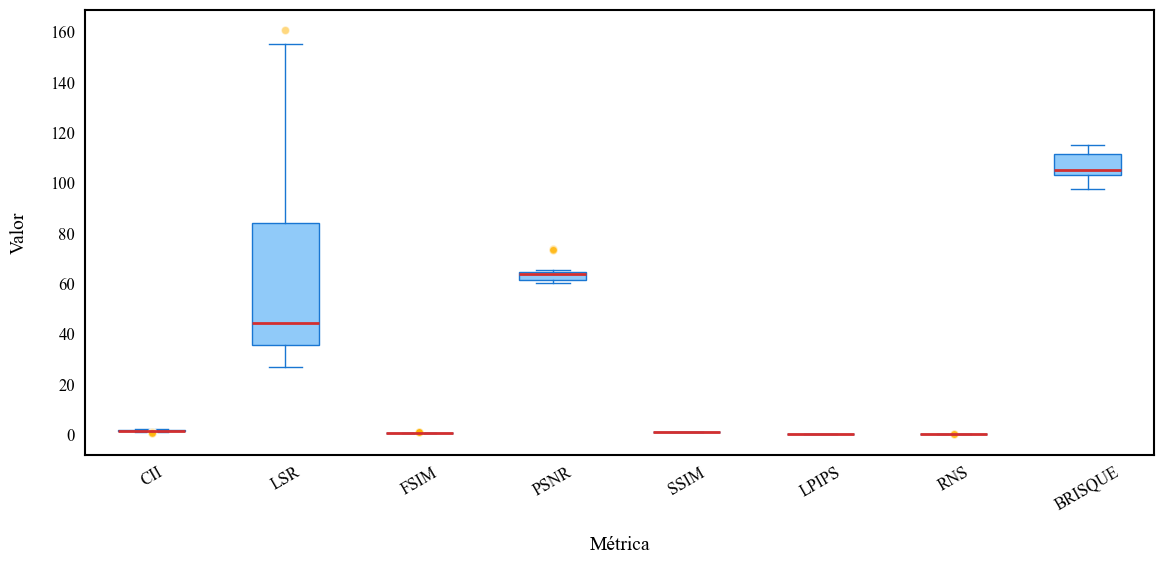

Exponential Scale Mask with decay_rate=0.01


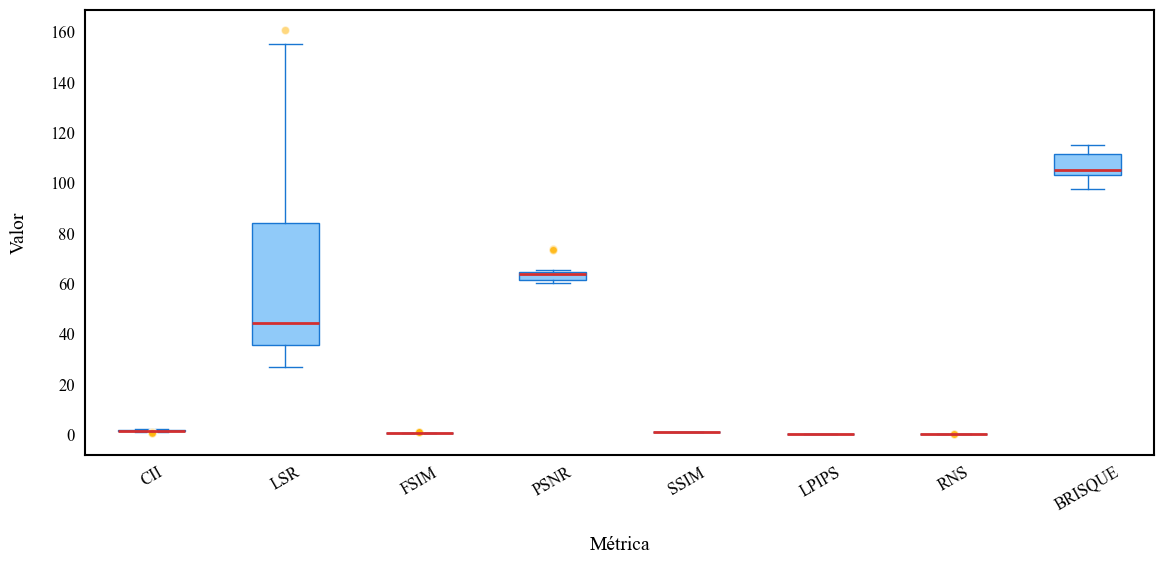

Highpass Mask with cutoff_scale=10


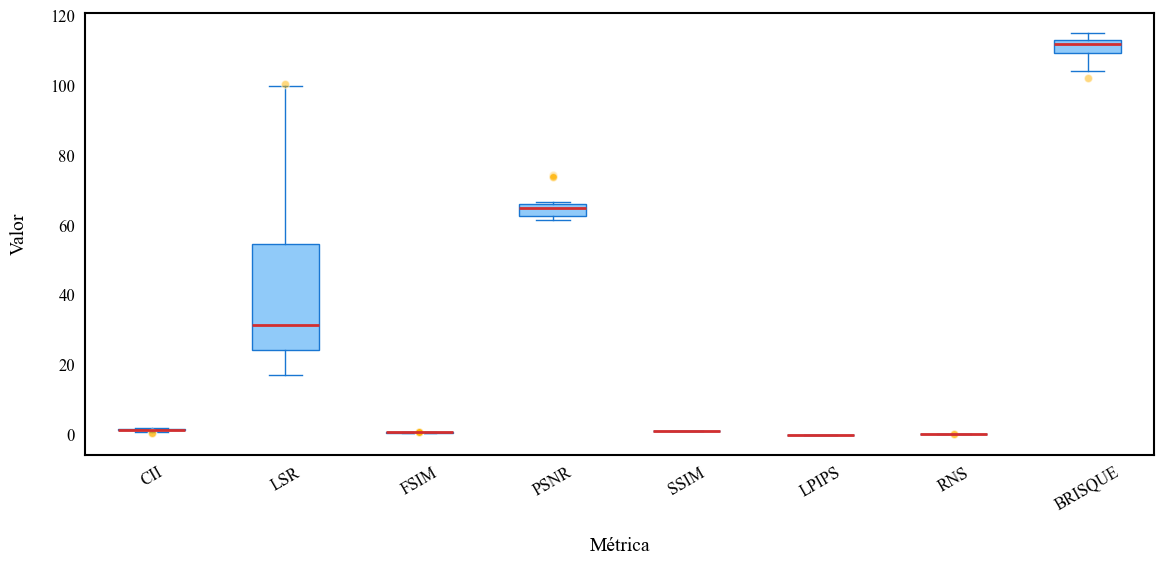

Gaussian Scale Mask with center_scale=N/2, sigma=1.0


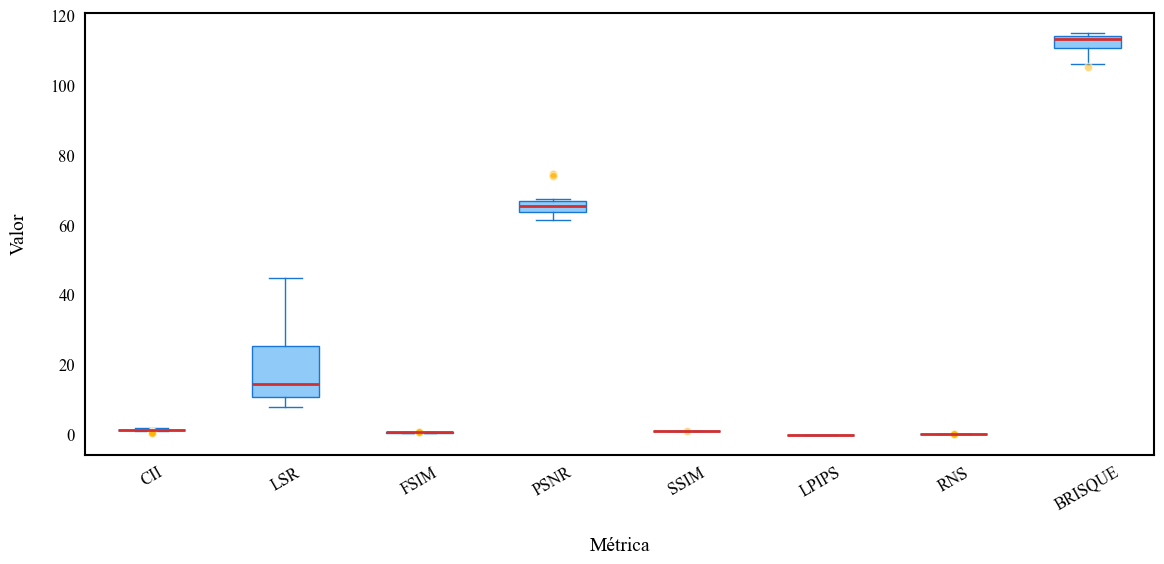

Bandpass Mask with low_scale=5, high_scale=10


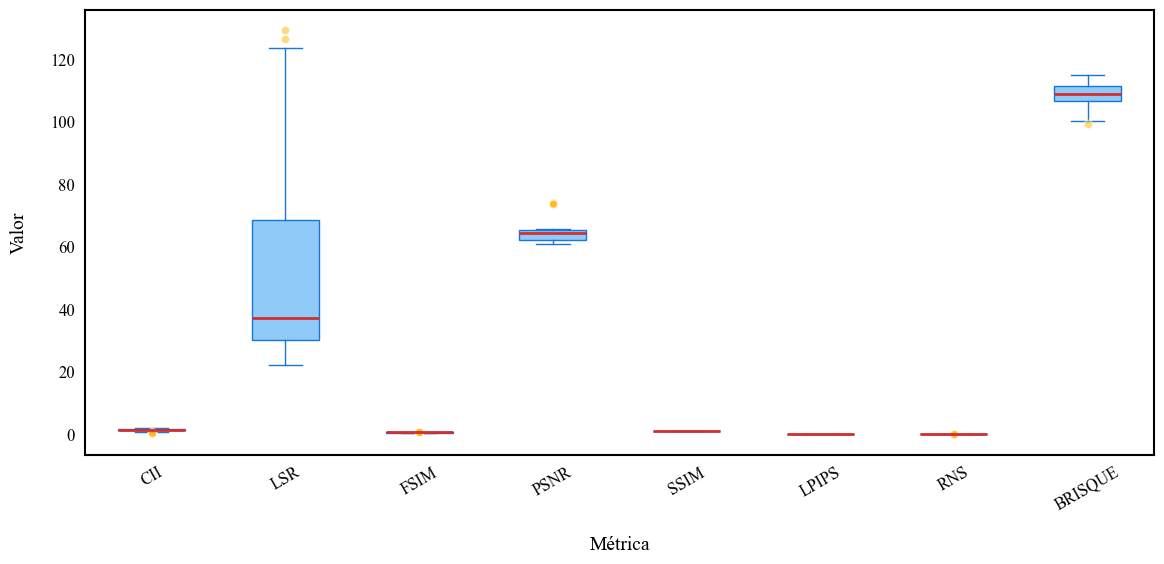

Enhance Energy by 10


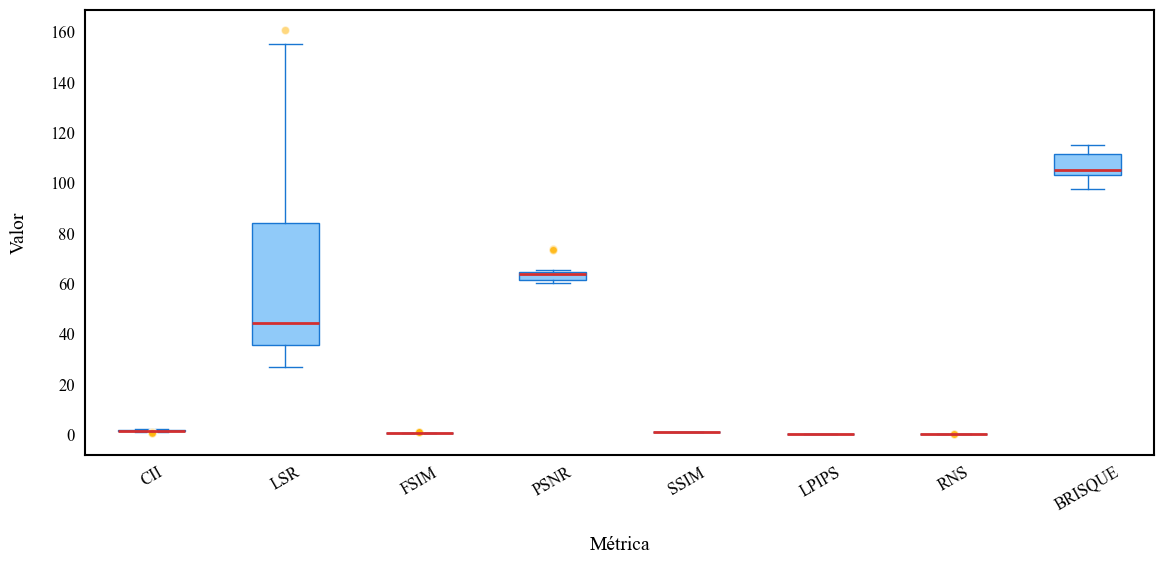

In [21]:
for exp in winners:
    print(exp)
    df = dfs[exp].drop(columns=["Experiment"])
    # Procesar nombres de métricas para mostrar solo la parte después de '::'
    metric_labels = [col.split('::')[-1] for col in df.columns]
    plt.figure(figsize=(12, 6))
    box = plt.boxplot(
        [df[col].dropna().values for col in df.columns],
        patch_artist=True,
        boxprops=dict(facecolor="#90caf9", color="#1976d2"),
        medianprops=dict(color="#d32f2f", linewidth=2),
        whiskerprops=dict(color="#1976d2"),
        capprops=dict(color="#1976d2"),
        flierprops=dict(markerfacecolor="#ffb300", marker="o", markersize=6, alpha=0.5)
    )
    plt.xticks(
        ticks=range(1, len(df.columns) + 1),
        labels=metric_labels,
        rotation=30,
        fontname="Times New Roman",
        fontsize=12,
        color="black"
    )
    plt.yticks(fontname="Times New Roman", fontsize=12, color="black")
    plt.xlabel("Métrica", fontname="Times New Roman", fontsize=14, color="black", labelpad=16)
    plt.ylabel("Valor", fontname="Times New Roman", fontsize=14, color="black", labelpad=16)
    plt.gca().set_facecolor("white")
    plt.gcf().set_facecolor("white")
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_color("black")
        spine.set_linewidth(1.5)
    plt.tight_layout(pad=2.0)
    plt.show()
    
    print("="*20)